<a href="https://colab.research.google.com/github/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/df-filtering/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 14 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 2s (258 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.

In [2]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
!mv accident.py\?raw\=true accident.py

--2020-12-05 22:34:03--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/main/accident.py?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/accident.py [following]
--2020-12-05 22:34:03--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/main/accident.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/accident.py [following]
--2020-12-05 22:34:03--  https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/main/accident.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.co

In [3]:
pip install osmnx

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 14.5MB 315kB/s 
     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 6.5MB 46.3MB/s 
     |████████████████████████████████| 11.6MB 43.8MB/s 
     |████████████████████████████████| 972kB 46.4MB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 14.8MB 344kB/s 
  Created wheel for Rtree: filename=Rtree-0.9.4-cp36-none-any.whl size=21768 sha256=4c75e09291e33fddca244b58197acb42f57f13de77efba1f6cb83e09f3fa09ec
  Stored in directory: /root/.cache/pip/wheels/ff/20/c5/0004ef7acb96745ec99be960053902b0b414a2aa2dcad5834e
Successfully built Rtree
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement foli

In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from accident import ACCIDENT

In [2]:
G = ox.graph_from_place('Toronto, Ontario, Canada', network_type='drive')

In [ ]:
#G = ox.consolidate_intersections(ox.project_graph(G), tolerance=30, rebuild_graph=True)

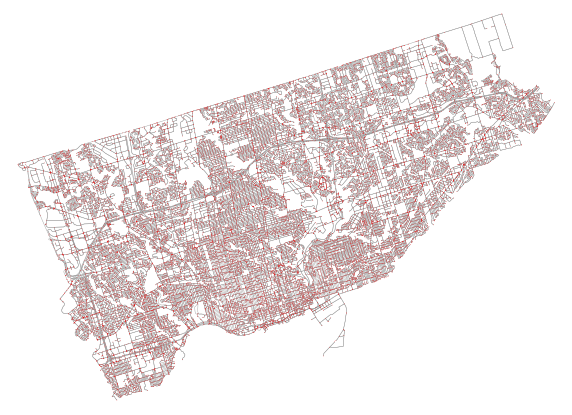

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph(G, bgcolor='white', node_size=0.3, node_color="red", edge_linewidth=0.4, edge_alpha=1, dpi=300, figsize=(10,10))

In [ ]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 27460
Number of edges: 73230
Average in degree:   2.6668
Average out degree:   2.6668


In [ ]:
edges =  list(G.edges.data())
edges[160]

(3463503,
 3463505,
 {'geometry': <shapely.geometry.linestring.LineString at 0x7f25d2d918d0>,
  'highway': 'secondary',
  'lanes': '4',
  'length': 119.022,
  'maxspeed': '50',
  'name': 'Lawrence Avenue East',
  'oneway': False,
  'osmid': 163720386})

In [ ]:
nodes =  list(G.nodes.data())
nodes[1]

(1497798, {'osmid': 1497798, 'x': -79.3355379, 'y': 43.7580721})

In [ ]:
nx.number_of_selfloops(G)

763

## KSI Dataset:

In [3]:
ksi_df = gpd.read_file("https://opendata.arcgis.com/datasets/cc17cc27ee5a4989b78d9a3810c6c007_0.geojson")

In [ ]:
ksi_df.head()

,Index_,ACCNUM,YEAR,DATE,TIME,HOUR,STREET1,STREET2,OFFSET,ROAD_CLASS,District,WardNum,Division,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_VEH,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,Neighbourhood,ObjectId,geometry
0,3389067,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,50 to 54,Major,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),1,POINT (-79.31880 43.69960)
1,3389068,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),2,POINT (-79.31880 43.69960)
2,3389069,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Driver,55 to 59,Minor,None,North,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),3,POINT (-79.31880 43.69960)
3,3389070,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,20 to 24,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),4,POINT (-79.31880 43.69960)
4,3389071,893184,2006,2006-01-01T05:00:00+00:00,236,2,WOODBINE AVE,O CONNOR DR,None,Major Arterial,Toronto and East York,19.0,54,43.699595,-79.318797,Intersection,Intersection Related,No Control,Clear,Dark,Wet,Non-Fatal Injury,Approaching,Passenger,15 to 19,Minor,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Yes,None,None,None,None,Yes,Yes,Yes,None,Yes,None,60,Woodbine-Lumsden (60),5,POINT (-79.31880 43.69960)


In [4]:
def assign_injury_index(injury:str):
  if injury == "Minimal":
    return 0.4
  elif injury == "Minor":
    return 0.6
  elif injury == "Major":
    return 0.8
  elif injury == "Fatal":
    return 1.0
  else:
    return 0.2

In [5]:
ksi_df["INJ_INDEX"] = ksi_df["INJURY"].apply(lambda x: assign_injury_index(x))

In [6]:
index_df = ksi_df[["ACCNUM", "INJ_INDEX"]].groupby(by="ACCNUM").sum()

Combining Date and Hour to have one single column:

In [7]:
ksi_df["DATE"] = pd.to_datetime(ksi_df['DATE']).dt.floor("D") + pd.to_timedelta(ksi_df["HOUR"], unit="hour")

Add datapoints to keep here:

In [8]:
cols_to_keep = ["LATITUDE", "LONGITUDE", "ACCNUM", "DATE", "VISIBILITY", "LIGHT",	"RDSFCOND"]
ksi_df = ksi_df[cols_to_keep]

Counting fatalities using duplicate rows:

In [9]:
fatalities = ksi_df["ACCNUM"].value_counts()
ksi_df["FATALITIES"] = ksi_df["ACCNUM"].apply(lambda x : fatalities[x])

In [10]:
ksi_df = ksi_df.drop_duplicates()
ksi_df.reset_index(drop=True, inplace=True)

In [11]:
ksi_df["G_NODE"]= ox.get_nearest_nodes(G, ksi_df["LONGITUDE"], ksi_df["LATITUDE"], method="balltree")
ksi_df.drop(["LATITUDE", "LONGITUDE"], axis=1, inplace=True)

In [12]:
ksi_df = ksi_df.merge(index_df, on="ACCNUM")

In [13]:
ksi_df = ksi_df.infer_objects()
ksi_df

,ACCNUM,DATE,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE,INJ_INDEX
0,893184,2006-01-01 02:00:00+00:00,Clear,Dark,Wet,8,33771082,4.2
1,909646,2006-01-01 03:00:00+00:00,Snow,"Dark, artificial",Slush,5,158754118,2.4
2,884090,2006-01-02 07:00:00+00:00,Other,"Dark, artificial",Wet,2,21631723,1.0
3,885782,2006-01-04 19:00:00+00:00,Rain,Dark,Wet,2,26007459,1.0
4,882079,2006-01-06 22:00:00+00:00,Clear,"Dark, artificial",Dry,2,259750208,1.0
...,...,...,...,...,...,...,...,...
5685,9002468442,2019-12-23 06:00:00+00:00,Clear,Dawn,Wet,2,86186677,1.0
5686,9002471073,2019-12-23 14:00:00+00:00,Clear,Daylight,Dry,3,287946845,1.8
5687,9002481518,2019-12-25 08:00:00+00:00,Clear,Daylight,Wet,2,1498033,1.0
5688,9002496688,2019-12-27 23:00:00+00:00,Clear,"Dark, artificial",Dry,2,392516842,1.0


Creating column of accident objects:

In [14]:
ksi_df["ACCIDENT"] = ksi_df.apply(lambda x: ACCIDENT(x["ACCNUM"], x["DATE"], x["VISIBILITY"], x["LIGHT"], x["RDSFCOND"], x["FATALITIES"], x["INJ_INDEX"]), axis=1)

In [15]:
ksi_df

,ACCNUM,DATE,VISIBILITY,LIGHT,RDSFCOND,FATALITIES,G_NODE,INJ_INDEX,ACCIDENT
0,893184,2006-01-01 02:00:00+00:00,Clear,Dark,Wet,8,33771082,4.2,"ACCIDENT(acc_id='893184', date=Timestamp('2006..."
1,909646,2006-01-01 03:00:00+00:00,Snow,"Dark, artificial",Slush,5,158754118,2.4,"ACCIDENT(acc_id='909646', date=Timestamp('2006..."
2,884090,2006-01-02 07:00:00+00:00,Other,"Dark, artificial",Wet,2,21631723,1.0,"ACCIDENT(acc_id='884090', date=Timestamp('2006..."
3,885782,2006-01-04 19:00:00+00:00,Rain,Dark,Wet,2,26007459,1.0,"ACCIDENT(acc_id='885782', date=Timestamp('2006..."
4,882079,2006-01-06 22:00:00+00:00,Clear,"Dark, artificial",Dry,2,259750208,1.0,"ACCIDENT(acc_id='882079', date=Timestamp('2006..."
...,...,...,...,...,...,...,...,...,...
5685,9002468442,2019-12-23 06:00:00+00:00,Clear,Dawn,Wet,2,86186677,1.0,"ACCIDENT(acc_id='9002468442', date=Timestamp('..."
5686,9002471073,2019-12-23 14:00:00+00:00,Clear,Daylight,Dry,3,287946845,1.8,"ACCIDENT(acc_id='9002471073', date=Timestamp('..."
5687,9002481518,2019-12-25 08:00:00+00:00,Clear,Daylight,Wet,2,1498033,1.0,"ACCIDENT(acc_id='9002481518', date=Timestamp('..."
5688,9002496688,2019-12-27 23:00:00+00:00,Clear,"Dark, artificial",Dry,2,392516842,1.0,"ACCIDENT(acc_id='9002496688', date=Timestamp('..."


## Dataset Filtering

VISIBILITY:

In [25]:
notclear_df = ksi_df.loc[~ksi_df.VISIBILITY.isin(["Clear"])]

In [26]:
clear_df = ksi_df.loc[ksi_df.VISIBILITY.isin(["Clear"])]

RDSFCOND:

In [32]:
dry_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Dry"])]

In [ ]:
wet_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Wet"])]

In [38]:
other_road_df = ksi_df.loc[~ksi_df.RDSFCOND.isin(["Dry", "Wet"])]

Time of Day:

## Processing a given Dataset

Set the Dataset to work on:

In [57]:
given_df = other_road_df

Collapsing dataset to get list of accidents for each node:

In [58]:
given_df = given_df.groupby('G_NODE')['ACCIDENT'].apply(list).reset_index(name='ACCIDENTS')

In [ ]:
given_df

Converting dataset to dict to set node attributes:

In [60]:
attr = given_df.set_index('G_NODE')['ACCIDENTS'].to_dict()

In [61]:
nx.set_node_attributes(G, [], "accident_list")
nx.set_node_attributes(G, attr, "accident_list")

Example Nodes:

In [ ]:
G.nodes[3458858]

In [ ]:
G.nodes[158754118]

In [53]:
#check if node has an accident list if so
#go through each edge on the node if the edge is connecting to a node that also has an injury index then
#add its length to the cumulative length
#W base = no of accidents * avg inj_index for each accident on the node
#distribute weight to edges as follows, total length/edge length * Wbase

def getEdgeWeights():
  #dictionary of edge tuples to weight
  weights = {}

  sumGraphWeights = 0 #used to get the sum of all injury indexes in the 
  sumGraphNodes = 0
  #loop through each node
  for node in given_df['G_NODE']:
    #if G.nodes[node]['accident_list'] !=[]:
    totalLen = 0     
    totalWeight = 0    
    sumGraphNodes += 1
    for edge in nx.edges(G, node):
      totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
    for x in G.nodes[node]['accident_list']:
      totalWeight += x.inj_index
      sumGraphWeights += x.inj_index
    baseWeight = totalWeight/len(G.nodes[node]['accident_list'])
    for edge in nx.edges(G, node):
      weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) * baseWeight
  
  avgWeight = sumGraphWeights/sumGraphNodes
  
  for node in G.nodes:
    if G.nodes[node]['accident_list'] == []:
      totalLen = 0
      totalWeight = 0
      for edge in nx.edges(G, node):
        totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
      for edge in nx.edges(G, node):
        weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) *avgWeight

  return weights


In [ ]:
weights = getEdgeWeights()
nx.set_edge_attributes(G, 0, 'w')
nx.set_edge_attributes(G, weights, 'w')
nx.get_edge_attributes(G, 'w')

In [ ]:
edges =  list(G.edges.data())
len(edges)

## PageRank

In [63]:
def pagerank_top_50(G):
  pr = nx.pagerank_scipy(G, weight='w')
  pr = pd.DataFrame.from_dict(pr, orient='index').sort_values(by=0, ascending=False).rename(columns={0:"PageRank Score"})
  return pr.iloc[:50]

In [64]:
pagerank_top_50(G)

,PageRank Score
21421640,0.000127
32424739,0.000126
32424740,0.000125
29657708,0.000124
85942894,0.000122
32499036,0.000122
430599203,0.000120
32412371,0.000119
32755967,0.000119
4392687493,0.000119


In [65]:
G.nodes[21421640]

{'accident_list': [],
 'highway': 'traffic_signals',
 'osmid': 21421640,
 'x': -79.3182411,
 'y': 43.726083}